# 🎓 Haruskah Saya Berkuliah Disini? Analisis Sentimen Terhadap Ulasan SIT Invercargill
**Penulis:** Syahdan Riyantyo Putro | **Tanggal:** 17 December 2025

## 1. Latar Belakang

Dalam proses pemilihan studi lanjut, Southern Institute of Technology (SIT) di Selandia Baru menjadi salah satu pilihan yang menarik perhatian setelah menghadiri pameran pendidikan internasional. Akan tetapi, muncul pertanyaan, "Apakah kampus ini memiliki reputasi yang baik atau tidak?". Untuk menjawab pertanyaan ini tidak cukup hanya dengan melihat rating bintang saja karena rating bisa saja bias atau tidak akurat.

Oleh karena itu, untuk menjawab pertanyaan tersebut akan dilakukan analisis sentimen terhadap ulasan yang diterima oleh Southern Institute of Technology (SIT) untuk melihat apakah publik memberikan penilaian yang baik terhadap kampus ini atau sebaliknya. Analisis yang dilakukan akan menggunakan algoritma VADER dan pendekatan Hybrid untuk mengklasifikasikan ulasan menjadi sentimen positif, negatif, atau netral.

# 2. Metodologi

## 2.1 *Data Collection*

Data yang digunakan diperoleh dari:
1. Google Maps Reviews: Diambil menggunakan metode scraping via Apify (sumber data utama),
2. Educational Portals: Data ulasan pelengkap diperoleh dari masterportal.com dan hotcoursesabroad.com.

## 2.2 *Data Preparation*

1. *Handling Missing Values*: Membuang data yang tidak memiliki ulasan (ulasan = NA),
2. *Data Type Conversion*: Menyesuaikan tipe data pada setiap kolom,
3. *Text Normalization*: Mengkonversi huruf menjadi huruf kecil (*lowercase*) dan membuang spasi berlebih (*whitespace removal*),
4. *Automated Audit*: Membuat fungsi untuk mendeteksi kata kotor (sensor kata, repetisi karakter, typo),
5. *Translation*: Menggunakan Google Translate API untuk menjaga data ulasan non-inggris tetap terpakai,
6. *Slang & Typo Correction*: Membuat fungsi untuk mengatasi masalah typo dan bahasa 'slang',
7. *Censored Word, Repeated Chars, Punctuation*: Membuat fungsi untuk menangani kata yang disensor, karakter berulang, dan menghilangkan tanda baca.

# 3. Analisis

Analisis yang dilakukan mencakup:
1. ***Sentiment Scoring***: Menggunakan **NLTK VADER** untuk menentukan sentimen positif atau negatif dari ulasan,
2. ***Hybrid Rule-Based Logic***: Menggabungkan skor sentimen dengan rating bintang (stars) untuk menangani ulasan yang bias (sarkasme atau sentimen implisit),
3. ***Keyword Extraction (WordCloud)***: Memvisualisasikan kata-kata yang dominan muncul pada ulasan positif maupun negatif,
4. ***N-Gram Analysis (Bi-gram)***: Melakukan Analisis Bi-gram untuk lebih memahami konteks pada ulasan positif dan negatif yang tidak dapat ditangkap oleh analisis unigram,
5. ***Hypothesis Testing (Drill Down)***: Melakukan Analisis Drill Down untuk menjawab hipotesis 'Apakah mahasiswa *online* lebih tidak puas dibandingkan mahasiswa tatap muka?',
6. ***Rolling Average Time Series***: Mengidentifikasi tren sentimen dari waktu ke waktu untuk melihat perubahan reputasi kampus.

# 4. Kode

## 4.1 *Import Library* dan *Configuration*

In [1]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import re
import time
import warnings
from deep_translator import GoogleTranslator
from langdetect import detect, LangDetectException
from textblob import TextBlob
from spellchecker import SpellChecker
from wordcloud import WordCloud, STOPWORDS

# Configuration
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
nltk.download('vader_lexicon', quiet=True)

True

## 4.2 *Import Data*

In [2]:
# 1. Load Data
df_review = pd.read_excel('data/google_review_SIT_Invercargill.xlsx') # Sesuaikan nama file
df_review.head(5)

,name,stars,text,publishedAtDate
0,Hamish Lane,5,"Rowanna from logistics was incredible, great c...",2025-01-08T00:58:54.521Z
1,Charli Blom,5,NaN,2021-02-14T22:10:55.509Z
2,Jacob Patchett,5,NaN,2020-10-27T05:45:13.436Z
3,Connor Peel,5,NaN,2025-11-07T10:04:16.231Z
4,Philip P. D.,1,My teachers in high school do a better job at ...,2025-10-09T04:45:12.942Z


## 4.3 *Preprocessing Data*

### 4.3.1 *Preprocessing Function*

In [5]:
# --- PREPROCESSING FUNCTIONS ---
# 1. Dirty Data Detector
def detect_dirty_issues(text):
    issues = []
    words = text.split()
    
    # --- 1. DETEKSI BAHASA (NON-INGGRIS) ---
    try:
        # Deteksi bahasa (jika teks terlalu pendek/aneh, kadang error)
        if len(text.split()) > 3: # Cek jika lebih dari 3 kata agar akurat
            lang = detect(text)
            if lang != 'en':
                issues.append('non_english')
    except LangDetectException:
        pass # Abaikan jika gagal deteksi
        
    # --- 2. DETEKSI TYPO (STRICT) ---
    # Jika ada 1 saja kata yang typo, langsung anggap ada typo.
    has_typo = False
    if len(words) > 0:
        for word in words:
            # Filter: Hanya cek kata > 3 huruf & alfabet saja (biar angka/simbol ga dianggap typo)
            if len(word) > 0 and word.isalpha():
                # Cek kamus
                corrected = str(TextBlob(word).correct())
                if word.lower() != corrected.lower():
                    has_typo = True
                    break # Langsung berhenti loop jika ketemu satu typo (hemat waktu)
    
    if has_typo:
        issues.append('typo')
    
    # 1. Deteksi Kata Disensor (Contoh: d**k, f**k, sh*t)
    # Regex mencari huruf + simbol bintang + huruf
    if re.search(r'\w+[\*]+\w+', text):
        issues.append('censored_word')
        
    # 2. Deteksi Tanda Baca Berlebihan (Contoh: "Bad service!!!!", "Why???...", ".....")
    # Regex mencari tanda baca (!, ?, .) yang muncul 3 kali berturut-turut atau lebih
    if re.search(r'[!?.]{3,}', text):
        issues.append('excessive_punct')
        
    # 3. Deteksi Repetisi Karakter (Contoh: "Goooooood", "Baaaaaad")
    # Mencari huruf yang diulang lebih dari 3 kali
    if re.search(r'(.)\1{3,}', text):
        issues.append('repeated_char')
        
    # 4. Deteksi Link/URL (Biasanya spam)
    if re.search(r'http\S+|www\.\S+', text):
        issues.append('contains_url')
        
    # 5. Deteksi Email (Masalah privasi)
    if re.search(r'\S+@\S+', text):
        issues.append('contains_email')

    # 6. Deteksi Terlalu Pendek (Kurang dari 3 kata - seringkali tidak bermakna)
    if len(text.split()) < 3:
        issues.append('too_short')

    # Return hasil
    if len(issues) == 0:
        return "Clean"
    else:
        return ", ".join(issues)

# 2. Data Cleaning Function

# Translator Initialization
translator = GoogleTranslator(source='auto', target='en')
spell = SpellChecker()

# register a brand name or special term so that it is not considered a typo
known_words = ['skype', 'zoom', 'whatsapp', 'google', 'youtube', 'online', 'wifi']
spell.word_frequency.load_words(known_words)

# CUSTOM_SLANG_DICT
CUSTOM_SLANG_DICT = {
    "gud": "good",
    "awsome": "awesome",
    "awsum": "awesome",
    "thx": "thanks",
    "plz": "please",
    "u": "you",
    "ur": "your",
    "b4": "before",
    "idk": "i do not know",
    "rn": "right now",
    "dont": "do not",
    "cant": "cannot",
    "wont": "will not",
    "im": "i am",
    "its": "it is",
    "recomend": "recommend",
    "slype": "skype"
}

# Fix Function
# 1. FIX NON-ENGLISH
def fix_translation(text):
    try:
        translated = translator.translate(text)
        time.sleep(0.2)
        return translated
    except:
        return text

# 2. FIX CENSORED WORDS
def fix_censored(text):
    replacements = {
        r"d\*\*k": "dick", r"f\*\*k": "fuck", r"sh\*t": "shit",
        r"b\*tch": "bitch", r"h\*ll": "hell", r"a\*\*": "ass"
    }
    for pattern, replacement in replacements.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    return text

# 3. FIX REPEATED CHARS
def fix_repeated_chars(text):
    # REVISI: Hanya targetkan HURUF (a-z atau A-Z).
    # Tanda baca seperti "!!!" tidak akan kena dampaknya di sini.
    # Contoh: "soooo" -> "soo", tapi "Wow!!!" tetap "Wow!!!"
    return re.sub(r'([a-zA-Z])\1{2,}', r'\1\1', text)

# 4. FIX PUNCTUATION
def fix_punctuation(text):
    # TAHAP A: Bersihkan simbol sampah (@, #, $) tapi sisakan ! ? . , '
    text = re.sub(r"[^a-zA-Z0-9\s!?,.']", '', text)
    
    # TAHAP B: Logika Spesifik User
    # 1. Tanda Titik (.): Jika ada 2 atau lebih (.. atau ...), ubah jadi 1 (.)
    text = re.sub(r'\.{2,}', '.', text)
    
    # 2. Tanda Seru (!) & Tanya (?): BIARKAN SAJA (Jangan di-replace)
    # VADER akan membaca "!!!" sebagai emosi yang lebih kuat daripada "!"
    
    return text

# 5. SMART TYPO FIXER
def smart_typo_fixer(text):
    # (Kode sama seperti sebelumnya: Kamus Slang + Spellchecker)
    words = text.split()
    fixed_words = []
    misspelled = spell.unknown(words)

    for word in words:
        lower_word = word.lower()
        if lower_word in CUSTOM_SLANG_DICT:
            fixed_words.append(CUSTOM_SLANG_DICT[lower_word])
        elif word in misspelled:
            correction = spell.correction(word)
            fixed_words.append(correction if correction else word)
        else:
            fixed_words.append(word)
    return " ".join(fixed_words)

# --- MAIN FUNCTION (Repair Review) ---
def repair_review(row):
    text = str(row['text_clean']) 
    issues = str(row['data_issues'])
    
    if 'non_english' in issues:
        text = fix_translation(text)
    
    if 'censored_word' in issues:
        text = fix_censored(text)
        
    if 'repeated_char' in issues:
        text = fix_repeated_chars(text)
        
    if 'excessive_punct' in issues: 
        text = fix_punctuation(text)
        
    if 'typo' in issues or 'many_typos' in issues or 'repeated_char' in issues:
        text = smart_typo_fixer(text)
        
    return text

### 4.3.2 *Cleaning Execution*

In [7]:
# --- CLEANING EXECUTION ---

print("Running Data Repair Pipeline... (This may take a moment)")

# Drop NA Review
df_reviewFiltered = df_review.dropna(subset=['text'])

# Change data type review into string and put it at new column
df_reviewFiltered['text_clean'] = df_reviewFiltered['text'].astype(str)

# Lowercase and Whitespace Removal
df_reviewFiltered['text_clean'] = df_reviewFiltered['text'].str.lower()
df_reviewFiltered['text_clean'] = df_reviewFiltered['text_clean'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

# Change data type publishedAtDate to datetime and Take the date only (Removing the hour and time zone)
df_reviewFiltered['publishedAtDate'] = pd.to_datetime(df_reviewFiltered['publishedAtDate'])
df_reviewFiltered['date_only'] = df_reviewFiltered['publishedAtDate'].dt.date

# Apply Dirty Data Detector
df_reviewFiltered['data_issues'] = df_reviewFiltered['text_clean'].apply(detect_dirty_issues)
# Apply Advanced Cleaning
df_reviewFiltered['text_final_fixed'] = df_reviewFiltered.apply(repair_review, axis=1)

print("Data Cleaning Complete!")
display(df_reviewFiltered.sample(5))

Running Data Repair Pipeline... (This may take a moment)
Data Cleaning Complete!


,name,stars,text,publishedAtDate,text_clean,date_only,data_issues,text_final_fixed
109,Dj manish 000,4,What are the courses available in it sir pleas...,2019-01-30 01:03:44.365000+00:00,what are the courses available in it sir pleas...,2019-01-30,typo,what are the courses available in it sir pleas...
57,stephen john luscombe,5,Great place to learn new hobbies and meet new ...,2023-11-30 20:04:23.507000+00:00,great place to learn new hobbies and meet new ...,2023-11-30,Clean,great place to learn new hobbies and meet new ...
78,Kate,2,SIT2LRN course for level 4 applied science was...,2021-07-05 22:18:33.943000+00:00,sit2lrn course for level 4 applied science was...,2021-07-05,typo,sit2lrn course for level 4 applied science was...
7,Shelley Bromley,5,I can't speak highly enough about SIT. I am c...,2022-03-31 22:57:11.622000+00:00,i can't speak highly enough about sit. i am cu...,2022-03-31,typo,i can't speak highly enough about sit i am cur...
106,Gerard McCall,5,Recently done Welding course - tutor Andy Youn...,2019-05-05 09:10:38.841000+00:00,recently done welding course - tutor andy youn...,2019-05-05,typo,recently done welding course - tutor and young...


## 4.4 Analisis

### 4.4.1 Sentiment Analysis

In [14]:
# Mengambil kolom yang diperlukan
target_cols = [
    'stars', 
    'date_only', 
    'text_final_fixed'
]

df_analysis = df_reviewFiltered[target_cols].copy()

# Initialization VADER
sid = SentimentIntensityAnalyzer()

# Function for Calculate Score
def get_sentiment(text):
    scores = sid.polarity_scores(str(text))
    
    # Assign Label based on Compund Score
    if scores['compound'] >= 0.05:
        return 'Positive'
    elif scores['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'
    
df_analysis['sentiment_category'] = df_analysis['text_final_fixed'].apply(get_sentiment)
df_analysis['sentiment_score'] = df_analysis['text_final_fixed'].apply(lambda x: sid.polarity_scores(str(x))['compound'])

display(df_analysis.sample(5))

,stars,date_only,text_final_fixed,sentiment_category,sentiment_score
37,5,2024-08-18,"good quality , flexible learning facilities ,t...",Positive,0.9349
106,5,2019-05-05,recently done welding course - tutor and young...,Positive,0.7425
128,5,2016-11-02,i m not a regular student in this campus searc...,Neutral,0.0000
124,4,2017-06-12,i hope you like my business and photos my busi...,Positive,0.6597
143,5,2015-09-02,sit - a great study experience the whole organ...,Positive,0.9670


Dari hasil analisis sentimen diatas, VADER memiliki permasalahan 'Salah Menilai' dimana ulasan dengan stars < 3 dikategorikan sebagai ulasan dengan sentimen positif. Hal ini dikarenakan VADER hanya mencocokkan kata-kata dalam kalimat dengan "kamus"
nilai emosiny dan tidak benar-benar memahami konteks dari ulasana Untuk mengatasi hal ini, dilakukan ***Hybrid Rule-Based Logic***, yaitu menggabungkan skor sentimen dengan rating bintang (stars) untuk menangani ulasan yang bias (sarkasme atau sentimen implisit)..

### 4.4.2 *Hybrid Rule-Based Logic*

In [16]:
# Pendekatan Hybrid
def get_hybrid_sentiment(row):
    text = str(row['text_final_fixed'])
    rating = row['stars'] # Pastikan kolom rating (1-5) ada
    
    # 1. Hitung skor VADER murni
    scores = sid.polarity_scores(text)
    compound_score = scores['compound']
    
    # 2. TERAPKAN LOGIKA HYBRID (VETO RULE)
    
    # KASUS A: Rating Sangat Rendah (1-2) tapi VADER bilang Positif/Netral
    # Kita paksa jadi Negatif
    if rating <= 2 and compound_score >= -0.05:
        return 'Negative'
        
    # KASUS B: Rating Sangat Tinggi (5) tapi VADER bilang Negatif
    # (Biasanya sarkasme positif atau salah deteksi slang)
    # Kita paksa jadi Positif
    elif rating >= 4 and compound_score <= 0.05:
        return 'Positive'
        
    # KASUS C: Sisanya ikuti VADER (Standar)
    else:
        if compound_score >= 0.05:
            return 'Positive'
        elif compound_score <= -0.05:
            return 'Negative'
        else:
            return 'Neutral'

# Terapkan fungsi ini menggunakan axis=1 (karena kita butuh data dari 2 kolom: text dan rating)
df_analysis['final_sentiment'] = df_analysis.apply(get_hybrid_sentiment, axis=1)

# Filter kasus aneh: Rating 1 tapi Skor VADER Asli > -0.05 (Netral/Positif)
check_fix = df_analysis[
    (df_analysis['stars'] == 1) & 
    (df_analysis['sentiment_score'] > -0.05)
]

# Tampilkan 5 sampel
print(f"Ditemukan {len(check_fix)} review yang berhasil dikoreksi menjadi 'Negative'.\n")

for index, row in check_fix.head(5).iterrows():
    print(f"Review: {row['text_final_fixed'][:100]}...") # Tampilkan 100 karakter pertama
    print(f"Rating Bintang : {row['stars']}")
    print(f"VADER Asli     : {row['sentiment_score']} (Seharusnya salah)")
    print(f"Label Baru     : {row['final_sentiment']} (Koreksi Hybrid)")
    print("-" * 50)

Ditemukan 6 review yang berhasil dikoreksi menjadi 'Negative'.

Review: horrible place to study online they do not give proper instructions and if you need help they might ...
Rating Bintang : 1
VADER Asli     : 0.3703 (Seharusnya salah)
Label Baru     : Negative (Koreksi Hybrid)
--------------------------------------------------
Review: this is an environment you would expect to have support and guidance in so you have the confidence t...
Rating Bintang : 1
VADER Asli     : 0.6003 (Seharusnya salah)
Label Baru     : Negative (Koreksi Hybrid)
--------------------------------------------------
Review: international students are not assessed properly are made to repeat courses losing is there is plent...
Rating Bintang : 1
VADER Asli     : 0.1531 (Seharusnya salah)
Label Baru     : Negative (Koreksi Hybrid)
--------------------------------------------------
Review: hello to whom it may concern,this is to let you know that i have enquired about the diploma in infor...
Rating Bintang : 1
V

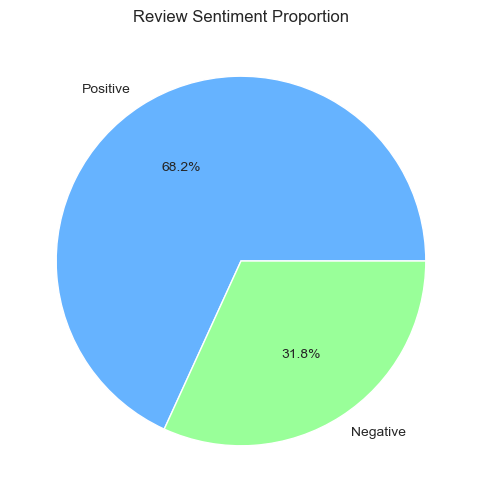

In [71]:
# Visualization Sentimen

# Proportion Sentiment
plt.figure(figsize=(6, 6))
df_analysis['final_sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['#66b3ff','#99ff99','#ff9999'])
plt.title('Review Sentiment Proportion')
plt.ylabel('')
plt.show()

Dari hasil visualisasi pie chart terhadap ulasan sentimen terlihat ulasan dengan sentimen positif mendominasi dengan persentase 68.2%. Akan tetapi, persentase ulasan negatif juga tergolong cukup tinggi dengan persentase sebesar 31.8%.

### 4.4.3 *Keyword Extraction (WordCloud)*

Selanjutnya visualisasi *WordCloud* akan dibuat untuk melihat kata-kata yang sering muncul dari setiap kategori sentimen.

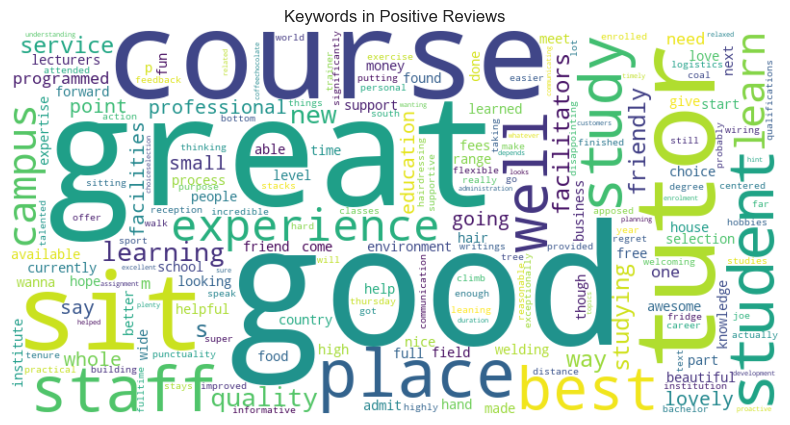

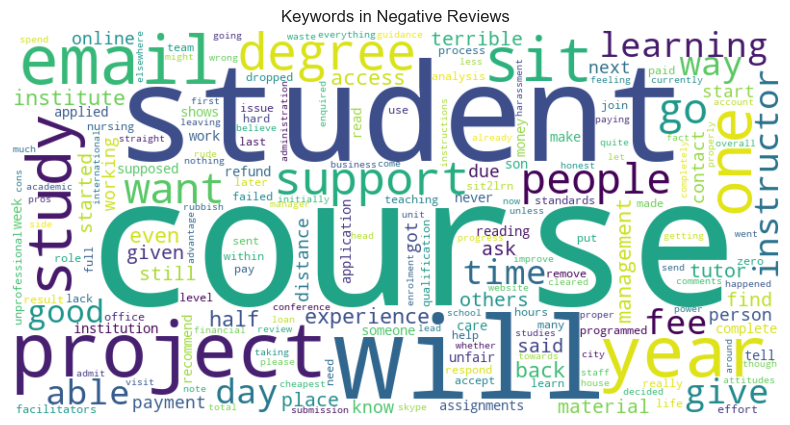

In [18]:
# Positive Sentiment
# Combine all positive review texts
text_positive = " ".join(review for review in df_analysis[df_analysis['final_sentiment'] == 'Positive']['text_final_fixed'])

# Create WordCloud
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", width=800, height=400).generate(text_positive)

# Show WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Keywords in Positive Reviews")
plt.show()

# Negative Sentiment
# Combine all negative review texts
text_negative = " ".join(review for review in df_analysis[df_analysis['final_sentiment'] == 'Negative']['text_final_fixed'])

# Create WordCloud
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", width=800, height=400).generate(text_negative)

# Show WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Keywords in Negative Reviews")
plt.show()

Dari hasil *WordCloud* terlihat pada sentimen positif didominasi oleh kata *great*, *good*, *staff*, dan *tutor* dan pada sentimen negatif didominasi oleh kata *student*, *project*, dan *email*. Hal menarik terlihat pada kata *course* yang muncul pada sentimen positif dan negatif. Akan tetapi hanya diketahui bahwa kata *course* adalah topik utama dari ulasan yang diterima oleh SIT. *Wordcloud* unigram tidak dapat menangkap konteks dari kata *course*. Oleh karena itu, dilakukan analisis N-Gram (Bi-gram) untuk menangkap kontek dari kata *course*.

### 4.4.4 *N-Gram Analysis (Bi-gram)*

Top 5 Frasa Positif: [('good quality', 3), ('admit staff', 2), ('professional staff', 2), ('great tutors', 2), ('small house', 2)]
Top 5 Frasa Negatif: [('distance learning', 3), ('course started', 3), ('place study', 3), ('projects role', 3), ('student loan', 2)]


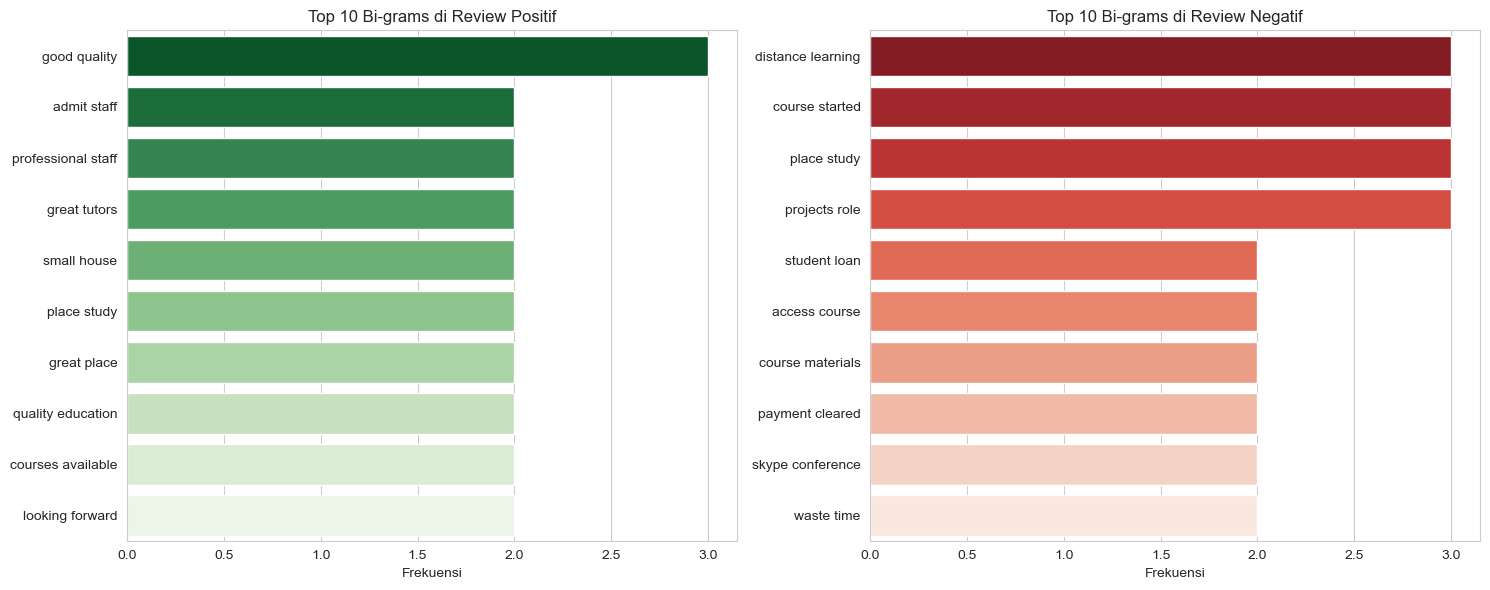

In [20]:
# Analysis Bi-Grams
# N gram = 2
def get_top_bigrams(corpus, n=10):
    # n_gram_range=(2, 2) mengambil 2 kata berurutan
    # stop_words='english': otomatis membuang kata the, and, is, of, dll.
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    
    # Menghitung frekuensi
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    
    # Mengurutkan dari yang terbanyak
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

# Pisahkan review berdasarkan kategori sentimen yang sudah kita buat sebelumnya
positive_reviews = df_analysis[df_analysis['final_sentiment'] == 'Positive']['text_final_fixed']
negative_reviews = df_analysis[df_analysis['final_sentiment'] == 'Negative']['text_final_fixed']

# Dapatkan 10 Bi-gram teratas untuk masing-masing
top_bi_pos = get_top_bigrams(positive_reviews, n=10)
top_bi_neg = get_top_bigrams(negative_reviews, n=10)

print("Top 5 Frasa Positif:", top_bi_pos[:5])
print("Top 5 Frasa Negatif:", top_bi_neg[:5])

# Visualization Bi-Grams

# Siapkan frame gambar
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot untuk Review Positif
x_pos, y_pos = zip(*top_bi_pos)
sns.barplot(x=list(y_pos), y=list(x_pos), ax=axes[0], palette='Greens_r')
axes[0].set_title('Top 10 Bi-grams di Review Positif')
axes[0].set_xlabel('Frekuensi')

# Plot untuk Review Negatif
x_neg, y_neg = zip(*top_bi_neg)
sns.barplot(x=list(y_neg), y=list(x_neg), ax=axes[1], palette='Reds_r')
axes[1].set_title('Top 10 Bi-grams di Review Negatif')
axes[1].set_xlabel('Frekuensi')

plt.tight_layout()
plt.show()

Dari analisis bi-gram ini terlihat bahwa frekuensi tertinggi muncul pada frasa *good quality*, *admit staff*, *professional  staff*, dan *great tutors*. Hal ini menunjukkan pemberi ulasan memiliki pengalaman yang positif terhadap kualitas pengajar dan staf pada kampus SIT. Akan tetapi kepuasan ini terbentur oleh pengalaman sistem pembelajaran jarak jauh (terlihat pada frasa *distance learning* mendominasi pada analisis bi-gram dan frasa *skype conference*) dan administrasi keuangan (terlihat pada frasa *student loan* dan *payment cleared* muncul pada bi-gram ulasan negatif).

Dari hasil analisis bi-gram ini muncul hipotesa "Apakah mahasiswa yang berkuliah secara *online* lebih tidak puas dibandingkan mahasiswa tatap muka?". Untuk menjawab hipotesa ini dilakukan *Hypothesis Testing (Drill Down)*.

### 4.4.5 *Hypothesis Testing (Drill Down)*

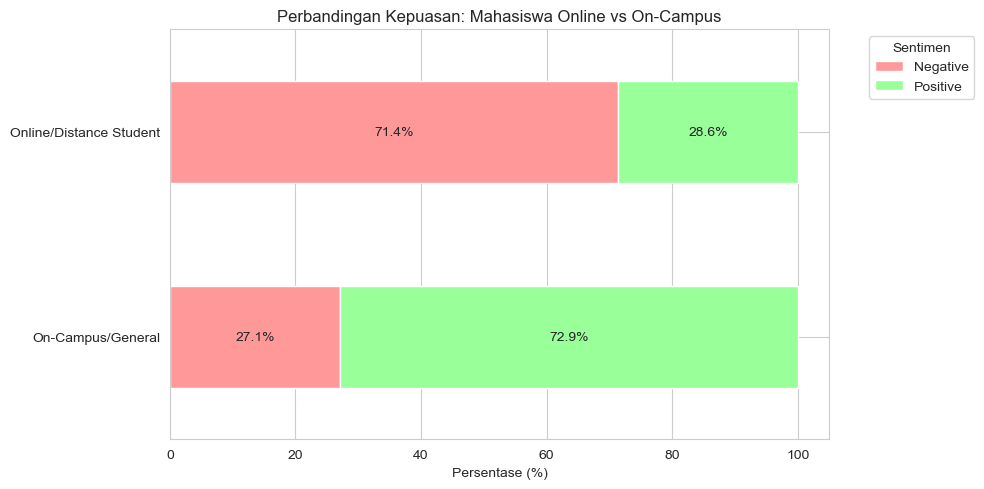

Jumlah Review per Kategori:
student_type
On-Campus/General          59
Online/Distance Student     7
Name: count, dtype: int64


In [22]:
# Analisis Drill Down (Online vs On-Campus Student)
# Hipotesis: Apakah mahasiswa online lebih tidak puas dibandingkan mahasiswa tatap muka?

# 1. Definisikan Kata Kunci untuk Mahasiswa Online
online_keywords = ['online', 'distance', 'zoom', 'skype', 'slype', 'remote', 
                   'internet', 'wifi', 'access', 'portal', 'login', 'website']

# 2. Fungsi Kategorisasi
def categorize_student_type(text):
    text = str(text).lower()
    # Cek apakah ada salah satu kata kunci online di dalam teks
    if any(keyword in text for keyword in online_keywords):
        return 'Online/Distance Student'
    else:
        return 'On-Campus/General'

# 3. Terapkan ke Dataframe
df_analysis['student_type'] = df_analysis['text_final_fixed'].apply(categorize_student_type)

# 4. Visualisasi Perbandingan (Stacked Bar Chart)
# Menghitung proporsi sentimen di tiap grup
sentiment_by_type = pd.crosstab(df_analysis['student_type'], df_analysis['final_sentiment'], normalize='index') * 100

# Plotting
ax = sentiment_by_type.plot(kind='barh', stacked=True, figsize=(10, 5), 
                            color=['#ff9999', '#99ff99', '#66b3ff']) # Merah, Hijau, Biru

plt.title('Perbandingan Kepuasan: Mahasiswa Online vs On-Campus')
plt.xlabel('Persentase (%)')
plt.ylabel('')
plt.legend(title='Sentimen', bbox_to_anchor=(1.05, 1), loc='upper left')

# Menambahkan label angka di batang
for c in ax.containers:
    ax.bar_label(c, fmt='%.1f%%', label_type='center')

plt.tight_layout()
plt.show()

# 5. Cek Data Statistiknya
print("Jumlah Review per Kategori:")
print(df_analysis['student_type'].value_counts())

Berdasarkan analisis ini terlihat bahwa mayoritas pemberi ulasan yang berkuliah secara *online* memiliki sentimen negatif terhadap kampus ini. Akan tetapi sebaliknya, mayoritas pemberi ulasan yang berkuliah secara tatap muka memiliki sentimen yang positif. Hasil analisis inipun menjawab hipotesa sebelumnya bahwa mahasiswa yang berkuliah secara *online* lebih merasa tidak puas dengan kampus ini.

*Catatan: Jumlah sampel untuk mahasiswa *online* sangatlah kecil (hanya 7 ulasan). Ini berbanding terbalik dengan jumlah sampel untuk mahasiswa tatap muka yang memiliki jumlah yang cukup solid (sebanyak 59 ulasan). Akan tetapi, ini tidak menutup fakta bahwa 5 dari 7 ulasan menganggap bahwa pembelajaran *online* dikampus ini tidak memuaskan dan tetap menjadi sinyal kuat bahwa adanya masalah.*

### 4.4.5 *Rolling Average Time Series*

Analisis ini bertujuan melihat tren sentimen dari waktu ke waktu untuk melihat perubahan reputasi kampus. Analisis ini dilakukan dengan menggunakan ***Rolling Average*** dengan ***Window***=15 dengan tujuan untuk menghaluskan noise dari data yang jarang dan mengungkapkan lintasan jangka panjang.

*Catatan: Dilakukan kalibrasi terhadap skor sentimen menggunakan logika 'Skor Tepercaya' untuk memastikan garis tren mencerminkan peringkat pengguna secara akurat.*

Sedang melakukan kalibrasi skor sentimen...
Kalibrasi berhasil!


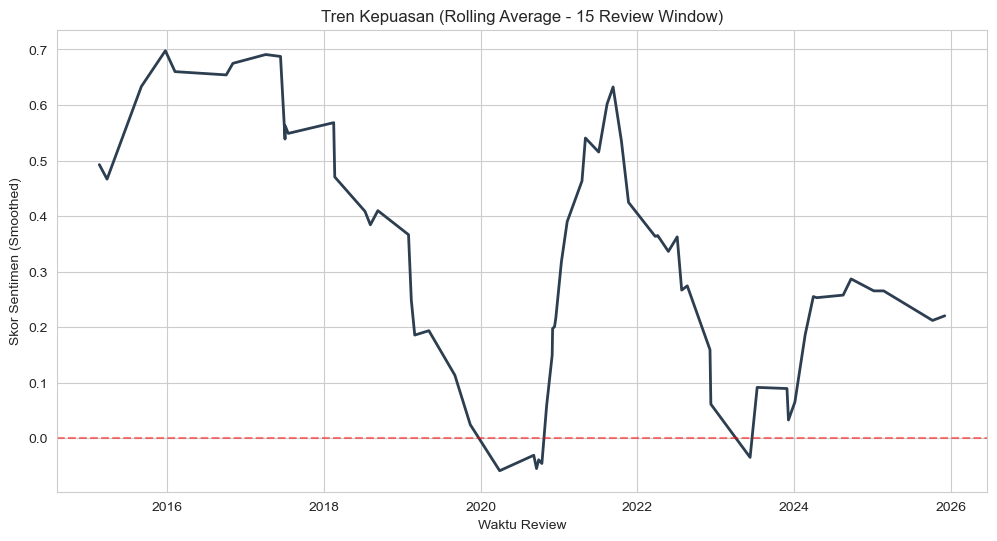

In [26]:
# Analisis Time Series
# Hitung score baru untuk sentimen score agar tidak tertipu dengan sentimen score yang positif akan tetapi memiliki final sentiment negative
def calculate_trusted_score(row):
    # Ambil data yang dibutuhkan
    vader_score = row['sentiment_score']
    final_label = row['final_sentiment']
    star_rating = row['stars']
    
    # KASUS 1: VADER dan Label SUDAH SEPAKAT
    # (Misal: Label Positive, Skor > 0.05 ATAU Label Negative, Skor < -0.05)
    if (final_label == 'Positive' and vader_score >= 0.05) or \
       (final_label == 'Negative' and vader_score <= -0.05):
        return vader_score

    # KASUS 2: KONFLIK (VADER Salah Deteksi)
    # Contoh: Orang sarkas "Great service" (Vader +0.6) tapi Bintang 1 (Label Negative)
    
    # Jika Label Akhir NEGATIVE, tapi skor VADER positif/netral
    if final_label == 'Negative':
        # Kita "hukum" skornya berdasarkan bintang
        # Bintang 1 -> Sangat Negatif (-0.8)
        # Bintang 2 -> Agak Negatif (-0.4)
        return -0.8 if star_rating == 1 else -0.4
    
    # Jika Label Akhir POSITIVE, tapi skor VADER negatif/netral
    elif final_label == 'Positive':
        # Bintang 5 -> Sangat Positif (0.8)
        # Bintang 4 -> Agak Positif (0.4)
        return 0.8 if star_rating == 5 else 0.4
    
    # KASUS 3: Netral
    else:
        return 0.0

# --- TERAPKAN KE DATAFRAME ---
print("Sedang melakukan kalibrasi skor sentimen...")
df_analysis['trusted_score'] = df_analysis.apply(calculate_trusted_score, axis=1)
print("Kalibrasi berhasil!")

# 1. Set tanggal sebagai index
df_analysis = df_analysis.set_index('date_only')
# 2. Sortir data berdasarkan tanggal dulu (Wajib!)
df_analysis = df_analysis.sort_index()

# 3. Hitung Rolling Mean
# window=30 artinya: "Setiap titik di grafik adalah rata-rata dari 30 review sebelumnya"
# min_periods=1 artinya: "Kalau datanya cuma ada 1, tetap hitung (jangan NaN)"
trend_data = df_analysis['trusted_score'].rolling(window=15, min_periods=1).mean()


# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(x=trend_data.index, y=trend_data.values, color='#2c3e50', linewidth=2)
plt.axhline(0, color='red', linestyle='--', alpha=0.5)

plt.title('Tren Kepuasan (Rolling Average - 15 Review Window)')
plt.xlabel('Waktu Review')
plt.ylabel('Skor Sentimen (Smoothed)')
plt.show()

Dari hasil visualisasi tren ini terlihat bahwa puncak tren kepuasan berada di tahun 2016, akan tetapi tren kemudian berangsur menurun hingga sampai di titik terendahnya pada tahun 2020 (yang kemungkinan disebabkan oleh pandemi COVID-19). Selanjutnya tren kepuasan terlihat mengalami pemulihan di tahun 2024-2025.

# 5. Kesimpulan dan Rekomendasi

## 5.1 Kesimpulan

Dari keseluruhan hasil analisis, dapat ditarik kesimpulan:

1. Southern Institute of Technology memiliki sistem akademik yang baik, terbukti dari pemberi ulasan secara konsisten memuji kualitas tutor dan mata kuliahnya.
2. Southern Institute of Technology memiliki kendala dalam pembelajaran secara *online* dimana pemberi ulasan mengeluhkan terkait pembelajaran jarak jauh (*distance learning* dan *skype conference*) dan memiliki kendala dalam administrasi keuangan (*student loan* dan *payment cleared*).
3. Kepuasan pemberi review sempat mengalami penurunan signifikan terutama pada tahun 2020-2021 yang kemungkinan diakibatkan oleh pandemi COVID-19. Akan tetapi tren kepuasan terlihat mengalami pemulihan mulai dari tahun 2024.

## 5.2 Rekomendasi

Southern Institute of Technology adalah pilihan yang baik secara akademis untuk pembelajaran secara tatap muka dan baiknya hindari pembelajaran jarak jauh jika memungkinkan. Akan tetapi, calon mahasiswa harus siap dengan kendala-kendala yang terjadi pada proses administratif.